# Vanguard Portfolio Optimizer

## Initialization

In [1]:
%matplotlib inline

In [2]:
import json
import typing

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import requests_cache
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
requests_cache.install_cache("requests_cache", backend="sqlite")

In [4]:
PRODUCT_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-list.json"
REQUEST_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-port-specific-price-history.json?vars=portId:{port_id},issueType:S,startDate:{start_date:%Y-%m-%d},endDate:{end_date:%Y-%m-%d}"
ASSET_COLOURS = {"BOND": "red", "EQUITY": "green"}
CUTOFF_YEAR = 2017

END_DATE = pd.to_datetime("2022-12-15")

## Get products descriptions

In [5]:
def get_products() -> pd.DataFrame:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)


def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def products_json_to_df(products_json) -> pd.DataFrame:
    return (
        pd.DataFrame(products_json.values())
        .assign(
            fees=lambda x: x["OCF"].str.slice(0, -1).astype(float) / 100,
            assets=lambda x: x["assetAllocations"].apply(len_or),
            inceptionDate=lambda x: pd.to_datetime(x["inceptionDate"]),
        )
        .reset_index(drop=True)
    )


raw_products_df = products_json_to_df(get_products())

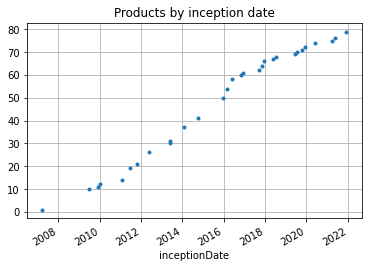

In [6]:
ax = (
    raw_products_df.groupby("inceptionDate")
    .size()
    .sort_index()
    .cumsum()
    .plot(grid=True, style=".")
)
_ = ax.set_title("Products by inception date")

## Filter products

* Keep only "Accumulation" products (their dividends are automatically reinvsted)
* Remove actively managed products
* Remove ESG/SRI products (they are highly correlated to the non ESG/SRI products)
* Remove recently created products (not enough historical data)

In [7]:
products_df = raw_products_df[
    lambda x: (x["distributionStrategyType"] == "ACCM")
    & x["assetCode"].isin(["BOND", "EQUITY"])
    & (x["managementType"] == "INDEX")
    & ~x["name"].str.startswith("ESG ")
    & ~x["name"].str.startswith("SRI ")
    & (x["inceptionDate"].dt.year <= CUTOFF_YEAR)
].reset_index(drop=True)

In [8]:
products_df[["name", "fees", "inceptionDate"]].sort_values("fees", ignore_index=True)

,name,fees,inceptionDate
0,FTSE U.K. All Share Index Unit Trust,0.0006,2009-12-04
1,FTSE 100 Index Unit Trust,0.0006,2016-11-08
2,U.S. Equity Index Fund,0.0010,2009-06-23
3,U.K. Short-Term Investment Grade Bond Index Fund,0.0012,2013-05-22
4,FTSE Developed Europe ex-U.K. Equity Index Fund,0.0012,2009-06-23
5,U.K. Government Bond Index Fund,0.0012,2009-06-23
6,U.K. Inflation-Linked Gilt Index Fund,0.0012,2011-02-03
7,U.K. Investment Grade Bond Index Fund,0.0012,2007-03-20
8,U.K. Long Duration Gilt Index Fund,0.0012,2011-02-03
9,U.S. Government Bond Index Fund,0.0012,2014-01-31


## Get products historical prices

In [9]:
histories = {}

for _, product in products_df.iterrows():
    port_id = product["portId"]
    url = REQUEST_URL.format(
        port_id=port_id, start_date=product["inceptionDate"], end_date=END_DATE
    )
    request = requests.get(url)
    assert request.status_code == 200

    histories[port_id] = json.loads(request.text)

In [10]:
sedols = products_df.set_index("portId")["sedol"].to_dict()
dfs = []
for port_id, history in histories.items():
    df = (
        pd.DataFrame(history)
        .assign(
            date=lambda x: pd.to_datetime(x["date"], utc=True)
            .dt.tz_localize(None)
            .dt.normalize()
        )
        .drop(columns=["mmNavPrice"])
        .rename(columns={"navPrice": "price"})
        .sort_values("date", ignore_index=True)
        .assign(
            sedol=sedols[port_id],
            day_return=lambda x: (x["price"] - x["price"].shift()) / x["price"].shift(),
        )
    )
    dfs.append(df)
historical_df = pd.concat(dfs, ignore_index=True)

In [11]:
sedol_to_name = products_df.set_index("sedol")["name"].to_dict()

## Explore products stats

In [12]:
pivoted_returns = (
    historical_df.pivot(index=["date"], columns=["sedol"], values=["day_return"])
    .droplevel(0, axis=1)
    .dropna(how="any")[lambda x: sorted(x.columns)]
)

In [13]:
yearly_returns_mean = ((1 + pivoted_returns.mean()) ** 252 - 1).rename(
    "yearly_return_mean"
)
yearly_returns_std = (pivoted_returns.std() * np.sqrt(252)).rename("yearly_return_std")
counts = pivoted_returns.count().rename("count")

stats = pd.concat([yearly_returns_mean, yearly_returns_std, counts], axis=1)

In [14]:
products_stats_df = products_df.join(stats, on="sedol")

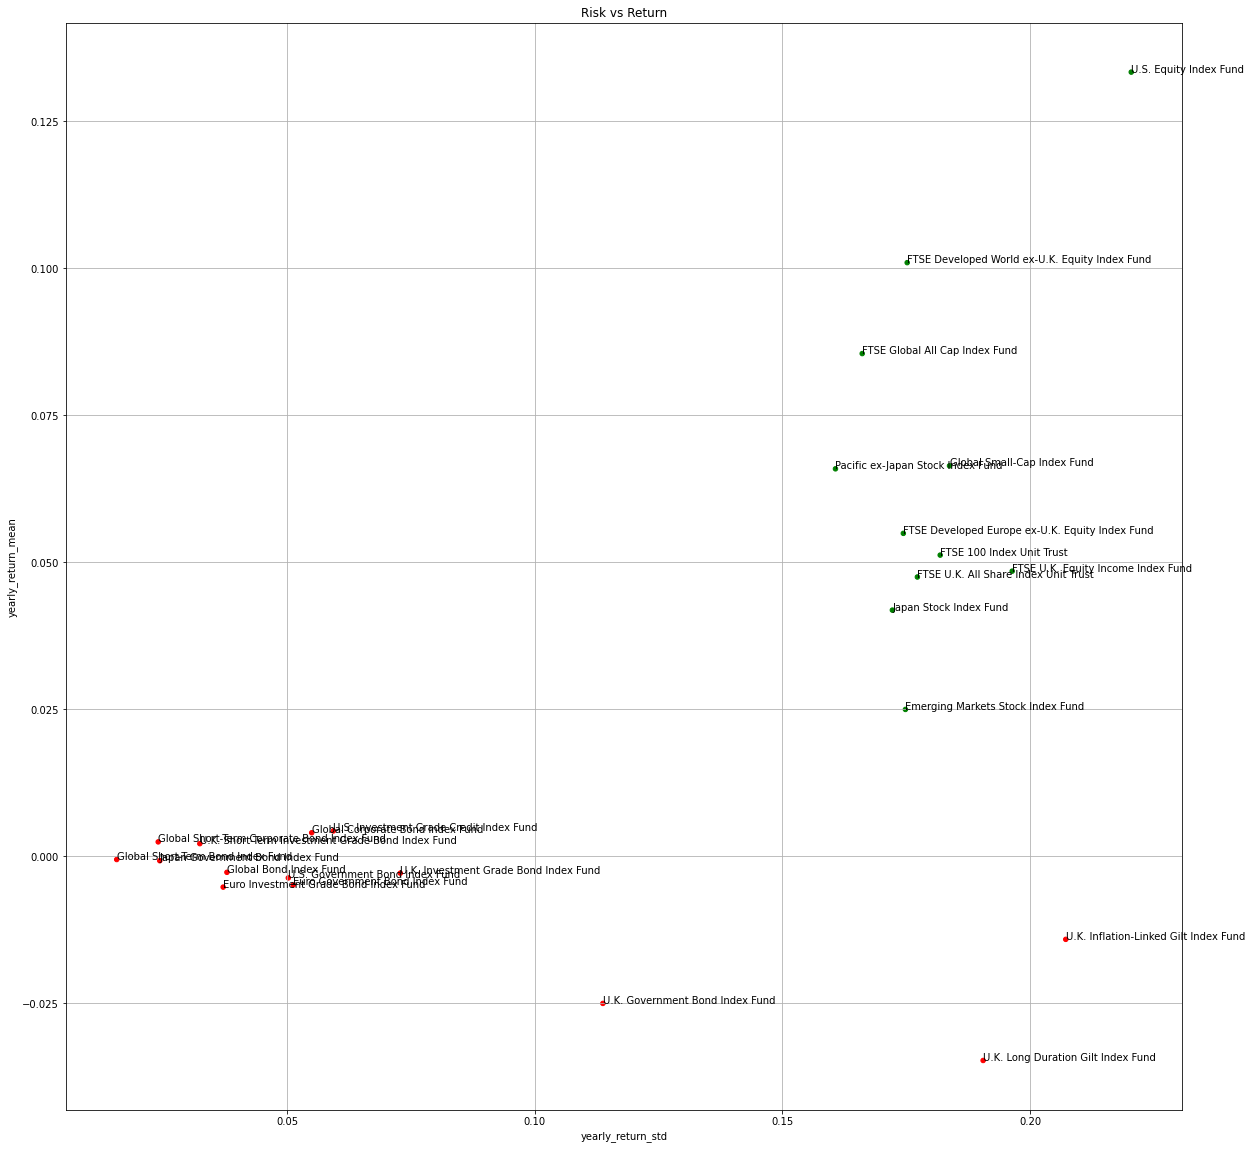

In [15]:
ax = (
    products_stats_df
    # .set_index('year_std')
    .plot.scatter(
        x="yearly_return_std",
        y="yearly_return_mean",
        grid=True,
        figsize=(20, 20),
        c=products_stats_df["assetCode"].map(ASSET_COLOURS),
    )
)


def label_point(x, y, val, ax):
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point["x"], point["y"], str(point["val"]))


label_point(
    products_stats_df["yearly_return_std"],
    products_stats_df["yearly_return_mean"],
    products_stats_df["name"],
    ax,
)
_ = ax.set_title("Risk vs Return")

In [16]:
pivoted_prices = historical_df.pivot(
    index="date", values="price", columns="sedol"
).dropna(how="any")

In [17]:
sorted_sedols = (
    pivoted_prices.div(pivoted_prices.iloc[0], axis=1)
    .iloc[-1]
    .sort_values(ascending=False)
    .index
)

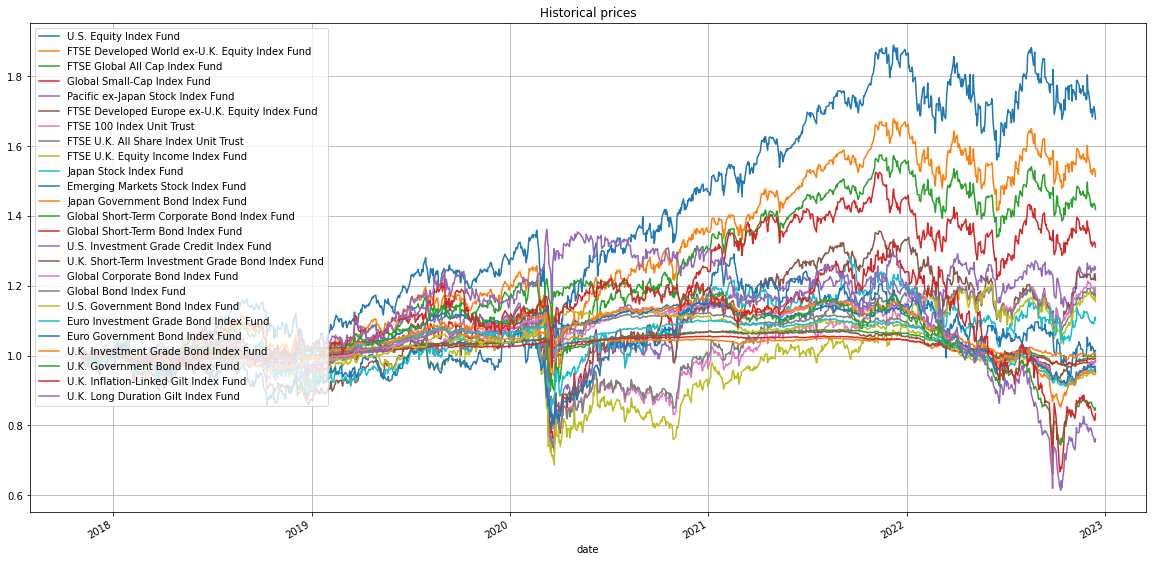

In [18]:
ax = (
    pivoted_prices.div(pivoted_prices.iloc[0], axis=1)[sorted_sedols]
    .rename(columns=sedol_to_name)
    .plot(figsize=(20, 10), title="Historical prices", grid=True)
)
_ = ax.legend(loc="upper left")

## Prepare optimization inputs

In [19]:
covariance = pivoted_returns.cov().sort_index()[lambda x: sorted(x.columns)]
expected_returns = pivoted_returns.mean()

In [20]:
class ProblemVariables:
    def __init__(self, expected_returns, covariance):

        assert (expected_returns.index == covariance.index).all()
        self.index = expected_returns.index
        er = expected_returns.to_numpy()
        cov = np.asmatrix(covariance.to_numpy())
        self.x = cp.Variable(len(expected_returns))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x

    def results(self):
        return self.ret.value, self.std()

    def std(self):
        return np.sqrt(self.vol.value)

    def year_std(self):
        return self.std() * np.sqrt(252)

    def year_return(self):
        return (1 + self.ret.value) ** 252 - 1

    def full_results(self):
        results = dict(zip(self.index, self.x.value))
        results["return"] = self.year_return()
        results["std"] = self.year_std()
        return pd.Series(results)

    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(
            solver="CVXOPT"
        )
        return self

    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(
            solver="CVXOPT"
        )
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
            [
                self.vol <= std_limit**2,
                cp.sum(self.x) == 1,
                self.x >= 0,
            ],
        ).solve(solver="CVXOPT")
        return self

    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()

        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pd.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
            [
                self.ret >= return_limit,
                cp.sum(self.x) == 1,
                self.x >= 0,
            ],
        ).solve(solver="CVXOPT")
        return self

    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value

        return_values = np.linspace(min_return, max_return, points)

        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pd.DataFrame(results)


std_ptfs = (
    ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)
)

## Plot results

In [21]:
def renormalize(df):
    row_sum = df.sum(axis=1)
    return df.div(row_sum, axis=0)


def plot_ptfs(ptfs, products_df, key="std"):
    assert key in ("std", "return")
    mapping = products_df.set_index("sedol")["name"].to_dict()

    return (
        ptfs.drop(columns=["return" if key == "std" else "std"])
        .set_index("std" if key == "std" else "return")
        .mask(lambda x: x < 0.01)
        .fillna(0)
        .loc[:, lambda x: (x != 0).any(axis=0)]
        .pipe(renormalize)
        .rename(columns=mapping)
        .plot.area(figsize=[20, 10], grid=True, legend="reverse")
    )

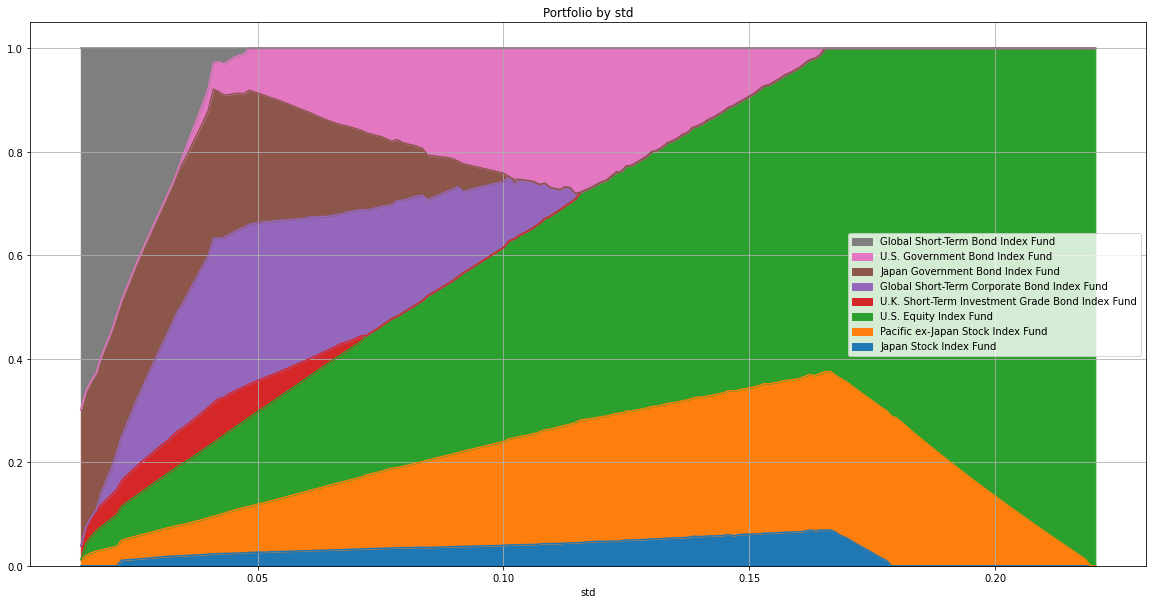

In [22]:
_ = plot_ptfs(std_ptfs, products_df, key="std").set_title("Portfolio by std")

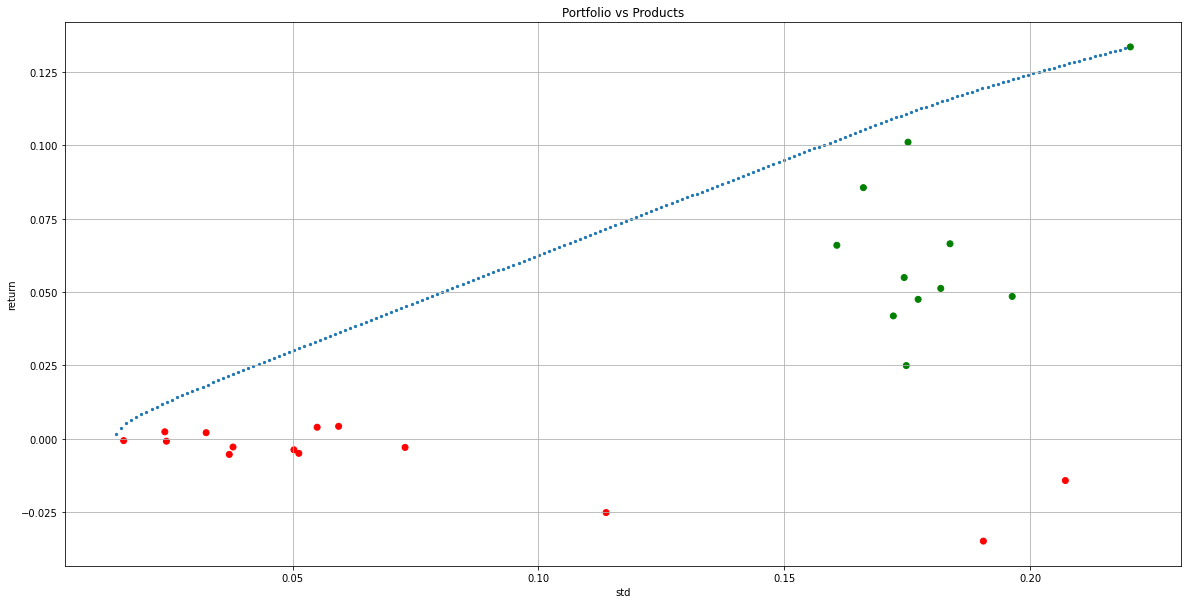

In [23]:
ax = std_ptfs.plot.scatter(x="std", y="return", grid=True, marker=".", figsize=(20, 10))
ax.scatter(
    x=products_stats_df["yearly_return_std"],
    y=products_stats_df["yearly_return_mean"],
    c=products_stats_df["assetCode"].map(ASSET_COLOURS),
)
_ = ax.set_title("Portfolio vs Products")

# Appendix 1: identifying redundant products

In [24]:
marginal_vifs = (
    pd.Series(
        [
            variance_inflation_factor(pivoted_returns.values, i)
            for i in range(len(pivoted_returns.columns))
        ],
        index=pivoted_returns.columns,
    )
    .sort_values()
    .rename("vif")
    .to_frame()
    .join(products_df.set_index("sedol")[["name"]])
)
marginal_vifs

,vif,name
sedol,,
BFRTD94,1.184855,Japan Government Bond Index Fund
B9M1BB1,1.725158,U.K. Short-Term Investment Grade Bond Index Fund
BDFB763,3.108723,Global Short-Term Corporate Bond Index Fund
B45Q903,3.507718,U.K. Inflation-Linked Gilt Index Fund
B1S74Q3,3.567619,U.K. Investment Grade Bond Index Fund
BFRTDC7,3.671952,U.S. Investment Grade Credit Index Fund
BFRTD83,3.829593,Euro Investment Grade Bond Index Fund
B523L31,3.838147,Pacific ex-Japan Stock Index Fund
BDFB5M5,4.231303,Global Corporate Bond Index Fund


In [25]:
def calculate_vifs(pr):
    removed = {}
    for i in range(len(pr.columns) - 1):
        vif = (
            pd.Series(
                [
                    variance_inflation_factor(pr.values, i)
                    for i in range(len(pr.columns))
                ],
                index=pr.columns,
            )
            .sort_values()
            .rename("vif")
        )
        removed[vif.index[-1]] = vif.iloc[-1]

        pr = pr[lambda x: [c for c in x.columns if c not in removed]]
    removed[pr.columns[0]] = 1
    return pd.Series(removed, name="vif").sort_values()


recursive_vifs = (
    calculate_vifs(pivoted_returns)
    .to_frame()
    .rename_axis("sedol")
    .join(products_df.set_index("sedol")[["name"]])
)
recursive_vifs

,vif,name
sedol,,
B59G4H8,1.000000,FTSE U.K. Equity Income Index Fund
BFRTD94,1.000223,Japan Government Bond Index Fund
B9M1BB1,1.004772,U.K. Short-Term Investment Grade Bond Index Fund
B50MZ94,1.055015,Japan Stock Index Fund
BFRTDC7,1.168504,U.S. Investment Grade Credit Index Fund
B5B71Q7,1.260143,U.S. Equity Index Fund
B45Q903,1.354420,U.K. Inflation-Linked Gilt Index Fund
B50MZ72,1.670256,Emerging Markets Stock Index Fund
BFRTD83,1.781453,Euro Investment Grade Bond Index Fund


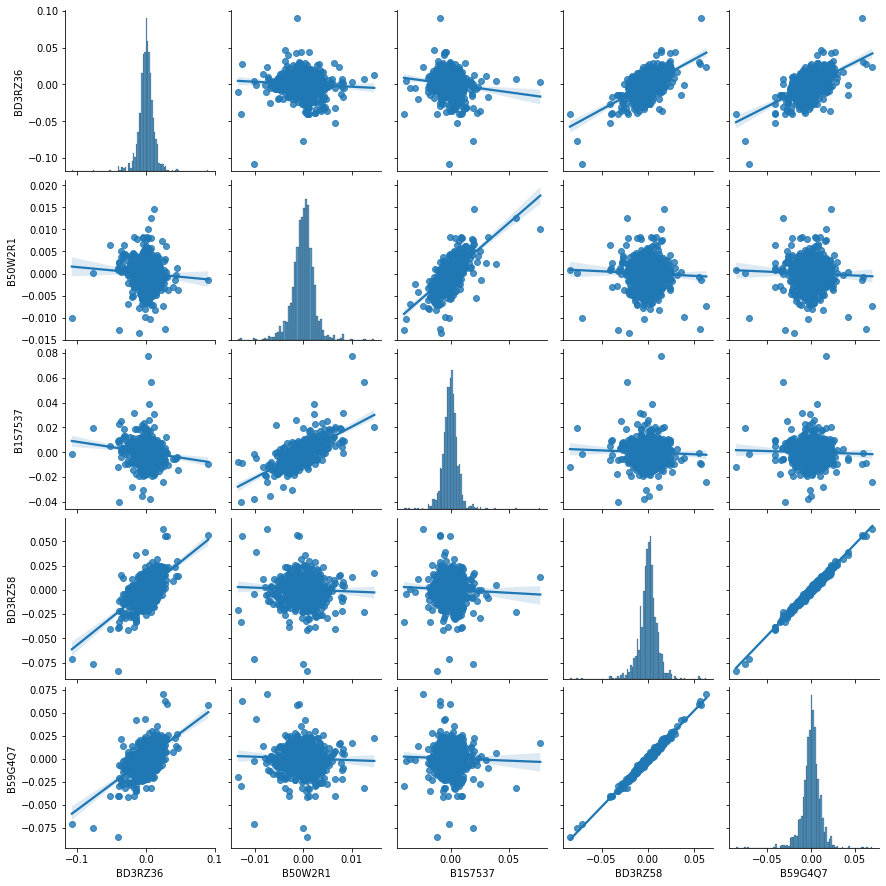

In [26]:
_ = sns.pairplot(pivoted_returns[recursive_vifs.index[-5:]], kind="reg")

# Appendix 2: Heat Map

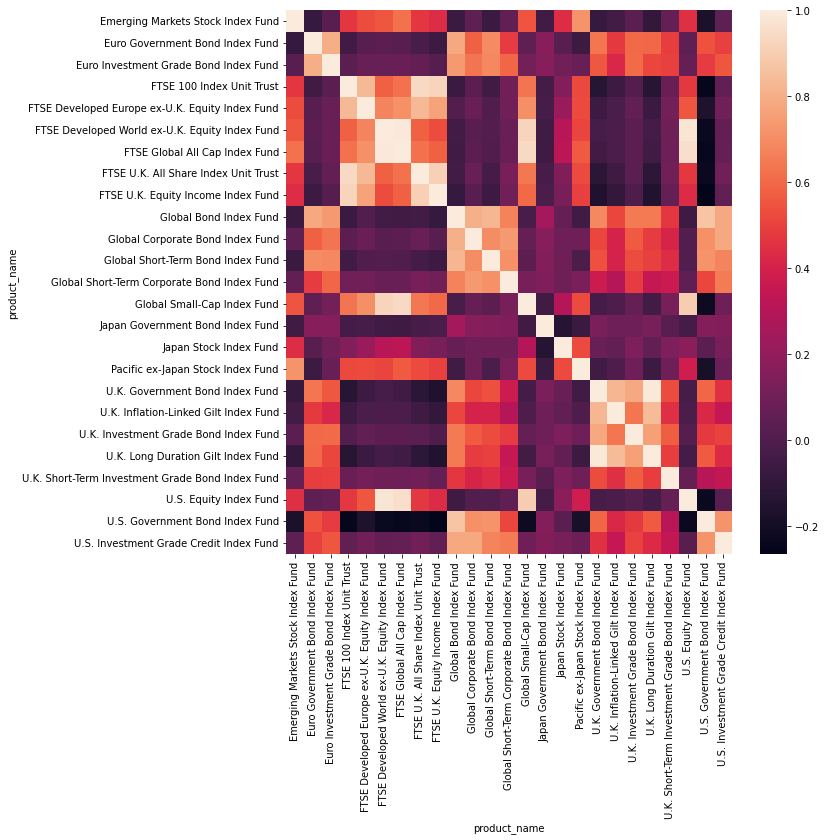

In [27]:
correlation = (
    pivoted_returns.rename(columns=products_df.set_index("sedol")["name"].to_dict())
    .rename_axis("product_name", axis=1)
    .corr()
    .sort_index()[lambda x: sorted(x.columns)]
)
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(correlation, ax=ax)

# Appendix 3: PCA

In [28]:
from sklearn.decomposition import PCA

returns_by_name = pivoted_returns.rename(
    columns=products_df.set_index("sedol")["name"].to_dict()
)

components_number = 5
pca = PCA(n_components=components_number)
X = returns_by_name[lambda x: ~x.isnull().any(axis=1)].to_numpy().T
X = X / X.std()
components = pca.fit_transform(X)
principal_df = pd.DataFrame(
    data=components, columns=[str(i + 1) for i in range(0, components_number)]
)
principal_df.set_index(returns_by_name.columns)

,1,2,3,4,5
sedol,,,,,
U.K. Investment Grade Bond Index Fund,16.622741,-1.250318,-0.037928,-1.681027,-0.287504
U.K. Government Bond Index Fund,25.819324,6.849782,-7.094163,2.388486,0.288404
Global Small-Cap Index Fund,-27.690795,15.933578,0.170691,-3.314816,2.649462
FTSE U.K. All Share Index Unit Trust,-25.006659,-15.497194,-16.311210,0.862179,2.211006
U.K. Inflation-Linked Gilt Index Fund,34.822000,17.915756,-23.387662,15.370440,-1.847024
U.K. Long Duration Gilt Index Fund,36.422149,16.405836,-18.089966,9.420523,0.774722
Emerging Markets Stock Index Fund,-16.617130,-2.165548,13.808994,18.777061,-20.370349
Japan Stock Index Fund,0.603119,-1.289005,24.189111,24.088364,21.925228
Global Bond Index Fund,14.102045,-5.022739,4.650758,-6.843999,-0.316220


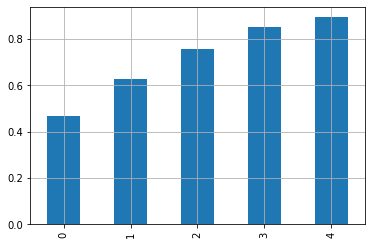

In [29]:
_ = pd.Series(pca.explained_variance_ratio_).cumsum().plot.bar(grid=True)